# Deep Fool

Experiments with the DeepFool algorithm from [Moosavi-Dezfooli, Frossard](https://github.com/LTS4/DeepFool/tree/master/Python). In order to use this notebook the DeepFool implementation has to be downloaded and the Python folder saved to `modules`.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

from IPython.display import clear_output

# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset

# Import DeepFool
from modules.DeepFool import deepfool

## 0. Load Model and Data

We load the pre-trained googleNet and the data.

In [2]:
# Get googleNet without the softmax layer

# Load pretrained net
model = models.googlenet(pretrained=True)

# Remove output layer
modules = list(model.children())[:-1]
googleNetMod = nn.Sequential(*modules)

for p in googleNetMod.parameters():
    p.requires_grad = False
    
googleNetMod.eval();

## Load full net for predictions later
googleNet = models.googlenet(pretrained=True)
googleNet.eval();

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

Using CPU
Number of iterations: 3
Adversarial class name: 242


True class index: 243
Predicted adversarial class index: 242
Adversarial confidence: 0.46


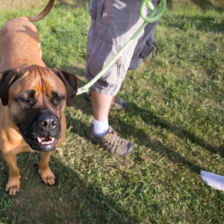

In [6]:
###### BASIC STEPS FOR DEEPFOOL

# Parameters
sample = 2


# Get image
image_clean, class_index = data_loader.dataset[sample]
image_clean.unsqueeze_(0)
class_index.unsqueeze_(0)

# Change dimension from (1, 3, 224, 224) to (3, 224, 224):
image_clean.squeeze_(0)

## Deep Fool attack
r_tot, loop_i, class_name_clean, class_name_adver, pert_image = deepfool.deepfool(image_clean, googleNet)
print("Number of iterations: {}".format(loop_i))
print("Adversarial class name: {}".format(class_name_adver))


## Test the adversary:
pred_class, confidences, _ = predict(googleNet, pert_image, class_index)
print("\n\nTrue class index: " +str(int(class_index.numpy().squeeze())))
print("Predicted adversarial class index: " +str(pred_class[0]))
print("Adversarial confidence: {:.2f}".format(confidences[0]))


show_tensor_image(pert_image)

## 2. All Images

We are splitting the data according to the original confidences. For each of the intervals we craft adversarial examples at varying epsilon and report the confidence and accuracy of these attacks for the interval.


### 2.1 Confidences for all samples where initial prediction is correct

In [ ]:
result = pd.DataFrame()

# Find examples with correct initial prediction
samples = []

for sample in range(1000):
    image_clean, class_index = data_loader.dataset[sample]
    image_clean.unsqueeze_(0)
    class_index.unsqueeze_(0)
    
    predicted_classes, _, _ = predict(model, image_clean.cpu(), class_index, return_grad=False)
        
    if predicted_classes[0] == class_index.cpu().squeeze().numpy():
        samples.append(sample)
        clear_output(wait=True)
        print("Identified correct clean predictions: {}".format(len(samples)))

        
result["Sample"] = samples

conf1 = []
conf2 = []
conf3 = []
conf4 = []
conf5 = []
num_iter = []
class_indices_clean = []
class_indices_adver = []
adver_succ = []

# Attack only if initial prediction is correct
counter = 1
for sample in samples:
    #clear_output(wait=True)
    print("Processing sample {} of {}".format(counter, len(samples)))
        
    # Get data
    image_clean, class_index = data_loader.dataset[sample]
    image_clean.unsqueeze_(0)
    class_index.unsqueeze_(0)

    # Change dimension from (1, 3, 224, 224) to (3, 224, 224):
    image_clean.squeeze_(0)

    # Deep Fool attack
    _, loop_i, class_index_clean, class_index_adver, pert_image = deepfool.deepfool(image_clean, googleNet)
    
    # Test image to get confidence
    pred_class, confidences, _ = predict(googleNet, pert_image, class_index)
    
    #assert(class_index_adver == pred_class[0])
    
    # Check for adversarial success. 1 If class changed, 0 if not
    if pred_class[0] == class_index.cpu().squeeze(0).numpy():
        adver_succ.append(0)
    else:
        adver_succ.append(1)
        
    
    # Save stats for sample
    num_iter.append(loop_i)
    class_indices_clean.append(class_index_clean)
    class_indices_adver.append(pred_class[0])  
    conf1.append(confidences[0])
    conf2.append(confidences[1])
    conf3.append(confidences[2])
    conf4.append(confidences[3])
    conf5.append(confidences[4])
    
    counter += 1

    
# Save results
result["Clean class"] = class_indices_clean
result["Adversarial class"] = class_indices_adver
result["Success"] = adver_succ
result["Iterations"] = num_iter
result["Confidence 1"] = conf1
result["Confidence 2"] = conf2
result["Confidence 3"] = conf3
result["Confidence 4"] = conf4
result["Confidence 5"] = conf5
    
# Save results
#result.to_csv("results/DeepFool/DeepFool-adversarial_confidences_corr_only.csv")

print("Done")

In [21]:
results_deepfool = pd.read_csv("results/DeepFool/DeepFool-adversarial_confidences_corr_only.csv", index_col=0)
results_deepfool

,Sample,Clean class,Adversarial class,Success,Iterations,Confidence 1,Confidence 2,Confidence 3,Confidence 4,Confidence 5
0,0,305,302,1,2,0.405431,0.405163,0.052673,0.020300,0.019363
1,2,243,242,1,3,0.463971,0.463751,0.007715,0.007259,0.002668
2,3,559,484,1,4,0.307119,0.306900,0.113108,0.031580,0.021042
3,4,438,470,1,3,0.112922,0.112779,0.018427,0.014210,0.014087
4,5,990,74,1,2,0.192529,0.191250,0.040914,0.028528,0.022305
...,...,...,...,...,...,...,...,...,...,...
839,994,141,98,1,4,0.376670,0.376455,0.019071,0.018698,0.017858
840,995,526,642,1,2,0.157194,0.156862,0.059688,0.040807,0.031531
841,996,703,765,1,3,0.216471,0.216409,0.082205,0.056809,0.039310
842,998,562,470,1,2,0.272588,0.272025,0.030797,0.024173,0.021818


In [39]:
results_fgsm = pd.read_csv("results/FGSM/FGSM-all_samples.csv", index_col=0)
results_bim = pd.read_csv("results/BIM/BIM-all_samples.csv", index_col=0)
results_illm = pd.read_csv("results/ILLM/ILLM-all_samples.csv", index_col=0)

In [35]:
conf_deepfool = []

for i in range(len(results_bim["Epsilon"])):
    conf_deepfool.append(results_deepfool["Confidence 1"].mean())
    

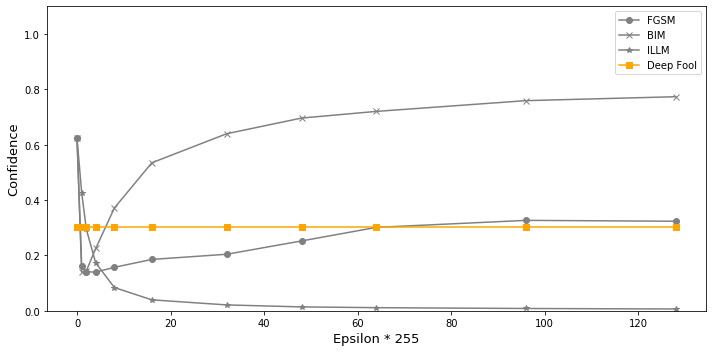

In [51]:
## Right: Confidences

fig, axs = plt.subplots(figsize=(10,5))

axs.plot(results_fgsm["Epsilon"], results_fgsm["Confidence"], "-o", color='grey', label='FGSM')
axs.plot(results_bim["Epsilon"], results_bim["Confidence"], "-x", color='grey', label='BIM')
axs.plot(results_illm["Epsilon"], results_illm["Confidence"], "-*", color='grey', label='ILLM')
axs.plot(results_fgsm["Epsilon"], conf_deepfool, "-s", color='orange', label='Deep Fool')
axs.set_ylabel("Confidence", fontsize=13)
axs.set_ylim(0, 1.1)

axs.legend()
axs.set_xlabel("Epsilon * 255", fontsize=13)

# Save plot
fig.tight_layout()
fig.savefig("plots/DeepFool/DeepFool-compare_attacks.png")

### 2.2 Confidence ranges

In [72]:
def confidence_range_attack_DeepFool(conf_range):
    '''
    Calculates the average confidences for DeepFool attacls for given confidence ranges of clean data.
    
    Inputs:
    conf_range  -- List of shape [min, max]
    
    Returns:
    confidences -- List of top 5 confidences
    '''
    

    assert(len(conf_range) == 2)
    
    min_confidence = conf_range[0]
    max_confidence =conf_range[1]
    
    # Get clean confidences and results deepfool
    results_clean = pd.read_csv("results/Clean-Predictions.csv", index_col=0)
    results_deepfool = pd.read_csv("results/DeepFool/DeepFool-adversarial_confidences_corr_only.csv", index_col=0)


    # Filter correct predictions
    samples = results_clean.loc[results_clean["Accuracy Top 1"] == 1]

    # Filter confidence
    samples = samples.loc[samples["Confidence 1"] > min_confidence]
    samples = samples.loc[samples["Confidence 1"] <= max_confidence]
    samples = samples.index.tolist()

    # Predict
    accurcy_top1 = []
    accurcy_top5 = []
    confidence_adversarial = []
    
    # Select samples from results_deepfool accordingly
    results_conf_range = results_deepfool[results_deepfool.Sample.isin(samples)]
    results_conf_range
    
    # Record the average confidence
    confidences = [np.mean(results_conf_range["Confidence 1"]), np.mean(results_conf_range["Confidence 2"]),
                  np.mean(results_conf_range["Confidence 3"]), np.mean(results_conf_range["Confidence 4"]),
                  np.mean(results_conf_range["Confidence 5"])]
    
    return confidences

In [73]:
conf_ranges = [[0.4, 0.6], [0.85, 0.9], [0.9, 0.95], [0.95, 0.99], [0.99, 1.00]]
conf_adversarial = []

for conf_range in conf_ranges:
    confidences = confidence_range_attack_DeepFool(conf_range)
    conf_adversarial.append(confidences[0])
    


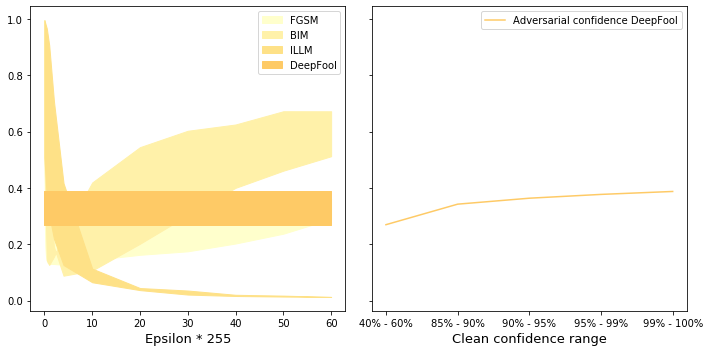

In [151]:
# Plot with other methods

# Load data FGSM
result_99_fgsm = pd.read_csv("results/FGSM/FGSM-Conf99.csv")
result_40_fgsm = pd.read_csv("results/FGSM/FGSM-Conf40.csv")

# Load data BIM
result_99_bim = pd.read_csv("results/BIM/BIM-Conf99.csv") 
result_40_bim = pd.read_csv("results/BIM/BIM-Conf40.csv")

# Load data ILLM
result_99_illm = pd.read_csv("results/ILLM/ILLM-Conf99.csv")
result_40_illm = pd.read_csv("results/ILLM/ILLM-Conf40.csv")

# Prepare data DeepFool
result_99_deepfool = []
result_40_deepfool = []

# Min
for i in range(len(result_99_illm["Epsilon_255"])):
    result_40_deepfool.append(conf_adversarial[0])
    
# Max
for i in range(len(result_99_illm["Epsilon_255"])):
    result_99_deepfool.append(conf_adversarial[4])
    
    
### Plots
cmap = plt.cm.get_cmap('YlOrRd')
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))

# Left plot: algorithms
axs[0].fill_between(result_99_fgsm["Epsilon_255"], result_40_fgsm["Confidence"], result_99_fgsm["Confidence"],
                   color=cmap(0), label="FGSM")
axs[0].fill_between(result_99_bim["Epsilon_255"], result_40_bim["Confidence"], result_99_bim["Confidence"],
                   color=cmap(0.1), label="BIM")
axs[0].fill_between(result_99_illm["Epsilon_255"], result_40_illm["Confidence"], result_99_illm["Confidence"],
                   color=cmap(0.2), label="ILLM")
axs[0].fill_between(result_99_illm["Epsilon_255"], result_40_deepfool, result_99_deepfool,
                   color=cmap(0.3), label="DeepFool")
axs[0].legend()
axs[0].set_xlabel("Epsilon * 255", fontsize=13)


# Right plot: DeepFool
axs[1].plot(["40% - 60%", "85% - 90%", "90% - 95%", "95% - 99%", "99% - 100%"], conf_adversarial, 
            color=cmap(0.3), label="Adversarial confidence DeepFool")
axs[1].set_xlabel("Clean confidence range", fontsize=13)
axs[1].legend()


## Save plot
fig.tight_layout()
fig.savefig("plots/DeepFool/DeepFool-Accuracies_Confidences.png")

## 3. Individual samples

-> Generate plots: Original image, adversary, top 5 confidence dist orig, top 5 conf dist adver

## References

[1] &emsp;  Moosavi-Dezfooli, S.-M., Fawzi, A., & Frossard, P. (2016). DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR).